# Science/non-science course prediction

This notebook contains a deep learning model which predicts whether a given higher education course is categorised into a 'Science', 'Non-science' or 'Combination' subject group based on its' title.

The Pytorch model comprises of:
- Embedding layer with averaged outputs
- Linear layer
- ReLu hidden layer
- Linear output layer

The model uses CrossEntropyLoss for the loss function and Adam for the opimizer.

Overall accuracy of the model on test data is 93%, however this is not a useful metric as the data is heavily imbalanced. Across the three categories, precision of the model on test data is 93%, 93% and 83% for 'Science', 'Non-science' or 'Combination' respectively.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from torchtext.data.utils import get_tokenizer
import nltk
import torch
import matplotlib.pyplot as plt
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchmetrics import Accuracy, F1Score, Precision, Recall
from sklearn.metrics import precision_recall_fscore_support as score

## Import and clean data

Data source: https://www.hesa.ac.uk/collection/c24061/

In [2]:
hesa_file = f"KISCOURSE"
hesa_folder = "on_2024_12_10_12_18_55"
hesa_loc = f"data/hesa/{hesa_folder}/{hesa_file}.csv"
hesa_dat = pd.read_csv(hesa_loc)

hecos_cah_lookup_loc = f"data/lookups/HECoS_CAH_Mappings.csv"
hecos_cah_lookup = pd.read_csv(hecos_cah_lookup_loc)

cah_level = 1

melted = hesa_dat[['UKPRN','HECOS', 'HECOS.1', 'HECOS.2', 'HECOS.3', 'HECOS.4', 'KISCOURSEID']].melt(id_vars=['UKPRN', 'KISCOURSEID'])

deduped = melted.drop(columns="variable").query("~value.isna()", engine="python").drop_duplicates()
deduped['value'] = deduped['value'].astype("int")

cah3_merged = pd.merge(deduped, hecos_cah_lookup[['HECoS_Code',f'CAH{cah_level}_Code']],
                       left_on="value", right_on="HECoS_Code", how="left")
cah3_merged['science'] = np.where(cah3_merged['CAH1_Code']<=13, 1, 0)

cah3_merged1 = cah3_merged.groupby("KISCOURSEID").agg({"science":["max", "nunique"]}).reset_index()
cah3_merged1.columns = cah3_merged1.columns.droplevel(0)
cah3_merged1 = cah3_merged1.rename(columns={'':"KISCOURSEID"})
cah3_merged1['cat'] = np.where(cah3_merged1['nunique']==2,
                               2,
                               cah3_merged1['max'])
cah3_merged1 = cah3_merged1[['KISCOURSEID', 'cat']]

cah3_merged2 = cah3_merged1.merge(hesa_dat[['KISCOURSEID', 'TITLE']])

cah3_merged2 = cah3_merged2.drop_duplicates(subset='KISCOURSEID').drop(columns="KISCOURSEID")



C:\Users\alexc\AppData\Local\Temp\ipykernel_10052\3306860898.py:4: DtypeWarning: Columns (3,5,7,10,22,27,29) have mixed types. Specify dtype option on import or set low_memory=False.
  hesa_dat = pd.read_csv(hesa_loc)


## Preprocess course titles

In [6]:
nltk.download('stopwords')

# Create a list of stopwords
stop_words = set(stopwords.words("english"))
additional_stopwords = ["(", ")", ",", "/", "&", "foundation",
                        "placement", "year", "integrated",
                        "bsc", "professional", "abroad", "4yr", "5yr"]
for additional_stopword in additional_stopwords:
    stop_words.add(additional_stopword)

# Initialize the tokenizer and stemmer
tokenizer = get_tokenizer("basic_english")
stemmer = PorterStemmer() 

# Complete the function to preprocess sentences
def preprocess_sentences(sentences):
    processed_sentences = []
    for sentence in sentences:
        sentence = sentence.lower()
		# Tokenize the sentence
        tokens = tokenizer(sentence)
		# Remove stop words
        tokens = [token.replace("/", " ") for token in tokens if token not in stop_words]
		# Stem the tokens
        tokens = [stemmer.stem(token) for token in tokens]
        processed_sentences.append(' '.join(tokens))
    return processed_sentences

titles_list = cah3_merged2['TITLE'].to_list()

processed = preprocess_sentences(titles_list)
cah3_merged2['processed'] = processed

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## EDA

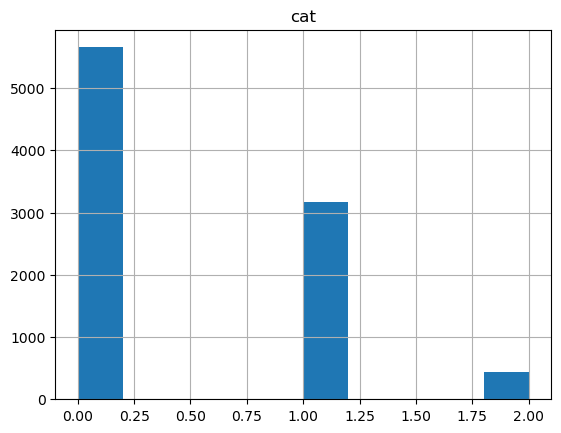

In [53]:
cah3_merged2.hist("cat")
plt.show()

## Split training, validation and test data

In [7]:
train, test_val = train_test_split(cah3_merged2,
                               test_size=0.3,
                               random_state=42,
                               stratify=cah3_merged2.cat
                               )
val, test = train_test_split(cah3_merged2,
                               test_size=0.3,
                               random_state=42,
                               stratify=cah3_merged2.cat
                               )

In [8]:
texts = list(train.processed.values)
labels = train.cat.to_list()

texts_val = list(val.processed.values)
labels_val = val.cat.to_list()

texts_test = list(test.processed.values)
labels_test = test.cat.to_list()

In [9]:
# Create vocab
def build_vocab(texts):
    def yield_tokens(texts):
        for text in texts:
            yield tokenizer(text)
    
    vocab = build_vocab_from_iterator(yield_tokens(texts))
    return vocab

vocab = build_vocab(texts)

6475lines [00:00, 113429.17lines/s]


## Initiate model

In [10]:
import torch.nn as nn
import torch.optim as optim

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.mean(dim=1)  # average the embeddings (one way to handle variable-length input)
        hidden = self.relu(self.fc1(embedded))
        output = self.fc2(hidden)
        return output

# Parameters
vocab_size = len(vocab)
embed_dim = 50
hidden_dim = 128
num_classes = len(cah3_merged2.cat.unique())  # for 3 targets

model = TextClassificationModel(vocab_size, embed_dim, hidden_dim, num_classes)


In [11]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        # Convert text to token indices
        tokens = tokenizer(text)
        token_ids = torch.tensor([self.vocab[token] for token in tokens], dtype=torch.long)
        return token_ids, label


def collate_fn(batch):
    # Sort the batch by sequence length (descending order)
    batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)
    
    # Unzip the batch into text and labels
    texts, labels = zip(*batch)
    
    # Pad the sequences
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)  # Assuming 0 is the padding index
    
    # Convert labels to tensor
    labels = torch.tensor(labels, dtype=torch.long)
    
    return padded_texts, labels


# Create dataset and dataloader
dataset = TextDataset(texts, labels, vocab)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

val_dataset = TextDataset(texts_val, labels_val, vocab)
val_dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [42]:
# Data is inbalanced - need to weight the labels in the loss function
class_weights = train.groupby(by="cat").processed.count().reset_index() / len(train)
class_weights = torch.FloatTensor(list(class_weights.processed.values))
class_weights

tensor([0.6113, 0.3421, 0.0466])

## Train model

In [43]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight = class_weights)  # For multi-class classification, weighted to the classes
learning_rates = [0.1, 0.01, 0.001, 0.0001]
learning_rate = learning_rates[1]
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
num_epochs = 5

# Training loop
loss_values = []
val_loss_values = []

# Initialize a list to store the average gradients for each epoch
embedding_gradients = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_gradient_sum = 0.0
    num_batches = 0

    for batch_idx, (inputs, targets) in enumerate(dataloader):
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()

        # Collect gradients for the embedding layer
        if 'embedding.weight' in model.state_dict():
            # Sum the gradients for this batch
            epoch_gradient_sum += model.embedding.weight.grad.abs().mean().item()
            num_batches += 1
        
        optimizer.step()
        
        running_loss += loss.item()

    # Calculate the average gradient for the embedding layer in this epoch
    avg_embedding_gradient = epoch_gradient_sum / num_batches if num_batches > 0 else 0
    embedding_gradients.append(avg_embedding_gradient)
    
    epoch_loss = running_loss/len(dataloader)
    loss_values.append(epoch_loss)
    # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():  # We don't need gradients for validation
        for inputs, targets in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()
            
            # Compute the number of correct predictions
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.size(0)
    
    # Compute the average validation loss and accuracy for this epoch
    avg_val_loss = running_val_loss / len(val_dataloader)
    accuracy = correct_predictions / total_predictions * 100
    val_loss_values.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch [1/5], Train Loss: 0.2278, Validation Loss: 0.1353, Accuracy: 93.81%
Epoch [2/5], Train Loss: 0.1481, Validation Loss: 0.1149, Accuracy: 93.61%
Epoch [3/5], Train Loss: 0.1328, Validation Loss: 0.1312, Accuracy: 93.78%
Epoch [4/5], Train Loss: 0.1726, Validation Loss: 0.1177, Accuracy: 94.22%
Epoch [5/5], Train Loss: 0.1232, Validation Loss: 0.0886, Accuracy: 94.58%


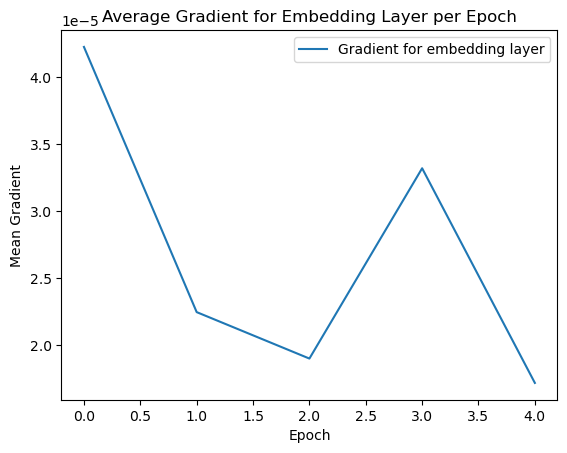

In [45]:
# Plot gradients for the embedding layer averaged across epochs
plt.plot(embedding_gradients, label='Gradient for embedding layer')
plt.title('Average Gradient for Embedding Layer per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean Gradient')
plt.legend()
plt.show()

In [46]:
test_titles_list = test['TITLE'].to_list()

test_processed = preprocess_sentences(test_titles_list)
test['processed'] = test_processed

## Predict on test data

In [47]:
def predict(model, text, vocab):
    model.eval()
    tokens = tokenizer(text)
    token_ids = torch.tensor([vocab[token] for token in tokens], dtype=torch.long).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(token_ids)
        _, predicted = torch.max(output, 1)
    return predicted.item()

# Example prediction
test_processed = preprocess_sentences(test['TITLE'].to_list())
preds = []
for i in range(len(test)):
    sentence = test_processed[i]
    predicted_class = predict(model, sentence, vocab)
    preds.append(predicted_class)
    # print(f"Predicted class: {predicted_class}")

test['preds'] = preds

In [48]:
test_dataset = TextDataset(texts_test, labels_test, vocab)

# Create DataLoader for the test set
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

def evaluate_model(model, test_dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():  # We don't need gradients for evaluation
        for inputs, targets in test_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item()

            # Compute the number of correct predictions
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == targets).sum().item()
            total_predictions += targets.size(0)
    
    # Compute the average test loss and accuracy
    avg_test_loss = running_test_loss / len(test_dataloader)
    accuracy = correct_predictions / total_predictions * 100
    
    return avg_test_loss, accuracy

test_loss, test_accuracy = evaluate_model(model, test_dataloader, criterion)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.8677
Test Accuracy: 92.15%


## Evaluate performance

In [51]:
# Create an instance of the metrics
accuracy = Accuracy(task="multiclass", num_classes=3)
precision = Precision(task="multiclass", num_classes=3)
recall = Recall(task="multiclass", num_classes=3)
f1 = F1Score(task="multiclass", num_classes=3)

# Calculate metrics for the model - overall metrics not that important here because of the class imbalance
actual = torch.tensor(test.cat.to_list())
pred = torch.tensor(preds)
accuracy_1 = accuracy(pred, actual) # y_pred_lstm = predictions, y_test = actual
precision_1 = precision(pred, actual)
recall_1 = recall(pred, actual)
f1_1 = f1(pred, actual)
print("Model - Accuracy: {}, Precision: {}, Recall: {}, F1 Score: {}".format(accuracy_1, precision_1, recall_1, f1_1))


Model - Accuracy: 0.926152765750885, Precision: 0.926152765750885, Recall: 0.926152765750885, F1 Score: 0.926152765750885


In [50]:
precision, recall, fscore, support = score(actual, pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.93122886 0.92020725 0.83783784]
recall: [0.9740566  0.93473684 0.23846154]
fscore: [0.95216138 0.92741514 0.37125749]
support: [1696  950  130]
